The task: *Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.*

In [1]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')
from collections import Counter

We first download and unzip the images then examine how they are organised

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [5]:
(path/'training').ls()

(#10) [Path('training/7'),Path('training/4'),Path('training/3'),Path('training/5'),Path('training/1'),Path('training/2'),Path('training/0'),Path('training/8'),Path('training/6'),Path('training/9')]

In [6]:
(path/'training/7').ls()

(#6265) [Path('training/7/20019.png'),Path('training/7/25115.png'),Path('training/7/26097.png'),Path('training/7/47385.png'),Path('training/7/29714.png'),Path('training/7/27635.png'),Path('training/7/16194.png'),Path('training/7/387.png'),Path('training/7/21483.png'),Path('training/7/13555.png')...]

We put all the filenames into a list of lists so that we may iterate over each digit in turn

In [7]:
files = []
for n in range(10):
    files.append((path/'training'/f'{n}').ls().sorted())

In [8]:
len(files[7])

6265

Lets show a random 8

In [9]:
im8_path = files[8][42]
im8 = Image.open(im8_path)
im8

Convert them to PyTorch tensors

In [10]:
tensors = []
for n in range(10):
    tensors.append([tensor(Image.open(f)) for f in files[n]])
len(tensors[7])

6265

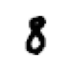

In [11]:
show_image(tensors[8][42]);

Stack them

In [12]:
stacked_tensors = []
for n in range(10):
    stacked_tensors.append(torch.stack(tensors[n]).float()/255)

In [13]:
stacked_tensors[7].shape

torch.Size([6265, 28, 28])

We are going to classify an image by compared it with each of the means for each number and choose the one that is most similar to a mean. So lets get the means

In [14]:
means = []
for n in range(10):
    means.append(stacked_tensors[n].mean(0))

Show the means

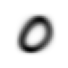

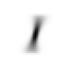

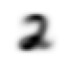

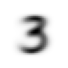

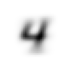

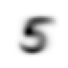

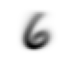

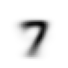

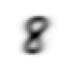

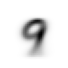

In [15]:
for n in range(10):
    show_image(means[n])

We can use either squared distance or absolute difference then take the mean across all pixels

In [16]:
def dist_sqr(x, n):
    return ((x - means[n])**2).mean().sqrt()

In [17]:
def dist_abs(x, n):
    return (x - means[n]).abs().mean()

As can be seen below both the squared and absolute would make the correct choice for our example

In [18]:
for n in range(10):
    print(f"Squared distance from mean {n} is {dist_sqr(stacked_tensors[7][42], n)}")

Squared distance from mean 0 is 0.3002283275127411
Squared distance from mean 1 is 0.2631435692310333
Squared distance from mean 2 is 0.2579994201660156
Squared distance from mean 3 is 0.2528550922870636
Squared distance from mean 4 is 0.23214493691921234
Squared distance from mean 5 is 0.24137316644191742
Squared distance from mean 6 is 0.2798610329627991
Squared distance from mean 7 is 0.17993471026420593
Squared distance from mean 8 is 0.2534157633781433
Squared distance from mean 9 is 0.20534631609916687


In [19]:
for n in range(10):
    print(f"Absolute distance from mean {n} is {dist_abs(stacked_tensors[7][42], n)}")

Absolute distance from mean 0 is 0.17530083656311035
Absolute distance from mean 1 is 0.11429698765277863
Absolute distance from mean 2 is 0.14882417023181915
Absolute distance from mean 3 is 0.13898836076259613
Absolute distance from mean 4 is 0.12255436182022095
Absolute distance from mean 5 is 0.13710539042949677
Absolute distance from mean 6 is 0.15445467829704285
Absolute distance from mean 7 is 0.09154555946588516
Absolute distance from mean 8 is 0.14000444114208221
Absolute distance from mean 9 is 0.10599169135093689


Lets collect the images used for testing

In [20]:
valids = []
for n in range(10):
    valids.append(torch.stack([tensor(Image.open(f)) for f in (path/'testing'/f'{n}').ls()]).float()/255)

Function below is the same as the mean calculation but for any two images

In [21]:
def distance(a, b): return (a - b).abs().mean((-1, -2))

In [22]:
distance(stacked_tensors[7][42], means[7])

tensor(0.0915)

In [23]:
distance(stacked_tensors[7], means[7])

tensor([0.1095, 0.1304, 0.1328,  ..., 0.1147, 0.1239, 0.0937])

Here is the classification function. It finds the distance for a image from each mean and classifies by choosing the smallest distance from the mean

In [24]:
def classify(x):
    dists = [distance(x, means[n]) for n in range(10)]
    return np.argmin(dists)

It gets our example correct

In [25]:
classify(stacked_tensors[7][42])

7

Here is the accuracy across the validation set. Notice how it is poor at classifying the 2s, 5, and 8s.

In [26]:
for n in range(10):
    print(f"Accuracy {n}: {sum(np.array([classify(x) for x in valids[n]]) == n) / len(valids[n])}")

Accuracy 0: 0.8153061224489796
Accuracy 1: 0.9982378854625551
Accuracy 2: 0.42344961240310075
Accuracy 3: 0.6089108910891089
Accuracy 4: 0.6680244399185336
Accuracy 5: 0.32623318385650224
Accuracy 6: 0.7870563674321504
Accuracy 7: 0.7645914396887159
Accuracy 8: 0.44250513347022585
Accuracy 9: 0.77601585728444


Lets look at the most common classifications for the digits that did not get classified well. We could imagine 5s could often be 8s maybe?

In [27]:
poor = [2, 5, 8]
for p in poor:
    classifications = Counter([classify(x) for x in valids[p]])
    percents = []
    for n in range(10):
        percents.append(classifications[n] / len(valids[n]))
    order = np.argsort(np.array(percents))[::-1][:3]
    for o in order:
        print(f"{p} classified as {o} {round(percents[o] * 100, 2)}% of time")
    print()
    

2 classified as 2 42.34% of time
2 classified as 1 39.3% of time
2 classified as 8 2.67% of time

5 classified as 5 32.62% of time
5 classified as 1 28.63% of time
5 classified as 3 14.36% of time

8 classified as 8 44.25% of time
8 classified as 1 32.69% of time
8 classified as 9 6.74% of time



So we see that using the distance from the mean to classify is problematic as 2s, 5s and 8s all get classified as 1s quite often.

## Now lets try using Stochastic Gradient Descent with a Neural Net

In [28]:
train_x = torch.cat(stacked_tensors).view(-1, 28*28)

In [29]:
classes = []
for n in range(10):
    classes += [n] * len(files[n])
train_y = tensor(classes).unsqueeze(1)

In [30]:
train_x.shape

torch.Size([60000, 784])

In [31]:
train_y.shape

torch.Size([60000, 1])

We create a dataset which needs to be a list of tuples of (x, y)

In [32]:
dset = list(zip(train_x, train_y))

In [33]:
valid_x = torch.cat(valids).view(-1, 28*28)

In [34]:
valid_x.shape

torch.Size([10000, 784])

In [35]:
valid_files = []
for n in range(10):
    valid_files.append((path/'testing'/f'{n}').ls().sorted())
classes = []
for n in range(10):
    classes += [n] * len(valid_files[n])
valid_y = tensor(classes).unsqueeze(1)

In [36]:
valid_y.shape

torch.Size([10000, 1])

In [37]:
valid_dset = list(zip(valid_x, valid_y))

In [38]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [39]:
weights = init_params((28*28,10))
bias = init_params(10)

In [40]:
def linear1(xb): return xb@weights + bias

In [41]:
preds = linear1(train_x)
preds.shape

torch.Size([60000, 10])

In [42]:
torch.argmax(preds, dim=1).unsqueeze(-1).shape

torch.Size([60000, 1])

In [43]:
train_y.shape

torch.Size([60000, 1])

In [44]:
corrects = torch.argmax(preds, dim=1).unsqueeze(-1).float() == train_y
corrects.shape

torch.Size([60000, 1])

In [45]:
corrects.float().mean().item()

0.12043333053588867

In [46]:
loss_func = nn.CrossEntropyLoss()

In [47]:
preds.shape, train_y.shape

(torch.Size([60000, 10]), torch.Size([60000, 1]))

In [48]:
def mnist_loss(preds, targs):
    return loss_func(preds, targs.reshape(-1))

In [49]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [50]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [51]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [52]:
calc_grad(xb, yb, linear1)
weights.grad.mean(), bias.grad.mean()

(tensor(-2.9194e-09), tensor(0.))

In [53]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [54]:
def batch_accuracy(xb, yb):
    preds = torch.argmax(xb, dim=1)
    return (preds == yb).float().mean()

In [55]:
batch_accuracy(xb, yb)

tensor(0.)

In [56]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [57]:
validate_epoch(linear1)

0.1275

In [58]:
lr = 10.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.2906

In [59]:
for _ in range(4):
    lr /= 10
    for i in range(40):
        train_epoch(linear1, lr, params)
        print(validate_epoch(linear1), end=' ')

0.5754 0.5944 0.6144 0.6281 0.6406 0.647 0.6524 0.6571 0.6611 0.6651 0.6653 0.6669 0.6676 0.6695 0.6697 0.6692 0.6683 0.6666 0.665 0.6631 0.6612 0.6596 0.6588 0.6568 0.655 0.6529 0.6512 0.651 0.6503 0.6487 0.6471 0.6445 0.6422 0.6411 0.6382 0.6357 0.6331 0.6314 0.6284 0.6256 0.7857 0.7941 0.7981 0.8016 0.8022 0.8045 0.8063 0.808 0.8089 0.8095 0.8098 0.811 0.8115 0.8117 0.812 0.812 0.8124 0.8122 0.8126 0.8128 0.8127 0.8126 0.8125 0.8123 0.8121 0.8118 0.8114 0.8117 0.811 0.8109 0.8106 0.8108 0.8108 0.8108 0.8105 0.8108 0.811 0.8112 0.8114 0.8113 0.8254 0.832 0.8337 0.8341 0.8352 0.836 0.836 0.836 0.8361 0.8363 0.8362 0.8362 0.8366 0.8368 0.8369 0.837 0.8372 0.8372 0.8372 0.8373 0.8374 0.8374 0.8375 0.8376 0.8376 0.8374 0.8377 0.8378 0.8378 0.8379 0.8379 0.8379 0.8378 0.8379 0.8383 0.8384 0.8383 0.8383 0.8382 0.8381 0.8381 0.838 0.838 0.838 0.838 0.8379 0.8376 0.8378 0.8378 0.8377 0.8376 0.8378 0.8379 0.838 0.838 0.838 0.8381 0.8381 0.8381 0.8381 0.8382 0.8382 0.8383 0.8383 0.8383 0.8384 

In [60]:
linear_model = nn.Linear(28*28,10)

In [61]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [62]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params = list(params)
        self.lr = lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [63]:
opt = BasicOptim(linear_model.parameters(), 1.)

In [64]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [65]:
validate_epoch(linear_model)

0.1049

In [68]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [69]:
train_model(linear_model, 40)

0.3973 0.4097 0.4163 0.4206 0.4232 0.4267 0.4291 0.4323 0.4345 0.4367 0.4391 0.4412 0.443 0.4449 0.4472 0.4495 0.4509 0.4528 0.4548 0.4559 0.4562 0.4572 0.4584 0.4591 0.4599 0.4608 0.4618 0.4626 0.4635 0.4647 0.4657 0.4666 0.4678 0.4687 0.4691 0.4699 0.4709 0.4721 0.4726 0.4736 

In [70]:
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.0707 0.096 0.1351 0.1753 0.2207 0.2604 0.299 0.3292 0.3648 0.3946 0.4277 0.4548 0.4841 0.5104 0.5348 0.5552 0.5724 0.5883 0.6011 0.6143 

In [71]:
dls = DataLoaders(dl, valid_dl)

In [72]:
learn1 = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [73]:
learn1.fit(10, lr=1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.922383,17.392626,0.154848,00:01
1,0.364467,15.189206,0.211841,00:01
2,0.277126,12.203425,0.276770,00:01
3,0.221491,10.137401,0.325807,00:01
4,0.200340,9.160206,0.351561,00:01
5,0.187660,8.649364,0.367913,00:01
6,0.179833,8.317805,0.378563,00:01
7,0.174005,8.026332,0.386127,00:01
8,0.169408,7.787348,0.391670,00:01
9,0.165681,7.598136,0.396811,00:01


Now we can try a larger model with 2 layers with 512 activations in each. Interestingly this models accuracy increases very slowly which you would think means the learning rate can be higher but I tried a learning rate of 1 and the loss went to infinity.

In [123]:
simple_net = nn.Sequential(
    nn.Linear(28*28,512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

In [124]:
learn2 = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

SuggestedLRs(lr_min=1905.4607421875, lr_steep=0.17378008365631104)

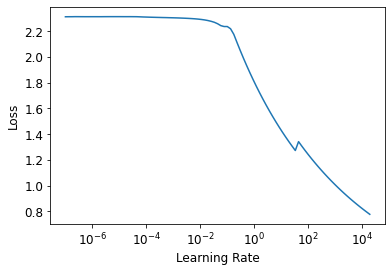

In [102]:
learn2.lr_find(end_lr=100000)

In [103]:
learn2.fit(10, 0.17)

epoch,train_loss,valid_loss,accuracy,time
0,0.448960,6.791012,0.100900,00:02
1,0.385578,6.495902,0.100900,00:02
2,0.292881,6.087780,0.100900,00:02
3,0.259876,5.323799,0.119500,00:02
4,0.221186,5.054850,0.177200,00:02
5,0.178438,4.542783,0.205600,00:05
6,0.146612,5.003828,0.157400,00:03
7,0.137301,4.764833,0.236400,00:03
8,0.118558,5.025231,0.202400,00:02
9,0.123761,5.009864,0.186400,00:02


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=0.02290867641568184)

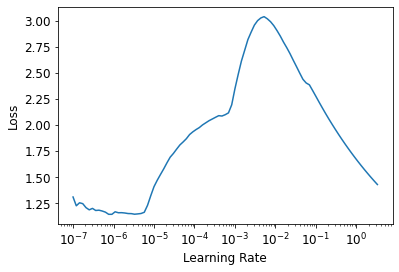

In [104]:
learn2.lr_find()

In [105]:
learn2.fit(10, 0.022908)

epoch,train_loss,valid_loss,accuracy,time
0,0.349226,2.788649,0.369000,00:07
1,0.281887,2.628011,0.401300,00:03
2,0.248379,2.416963,0.420600,00:03
3,0.229798,2.195495,0.439000,00:02
4,0.214571,2.030004,0.454400,00:02
5,0.201582,1.912302,0.466700,00:02
6,0.190985,1.815010,0.477900,00:02
7,0.182738,1.733312,0.488000,00:02
8,0.176128,1.663388,0.499900,00:02
9,0.170794,1.604577,0.507900,00:02


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.033113110810518265)

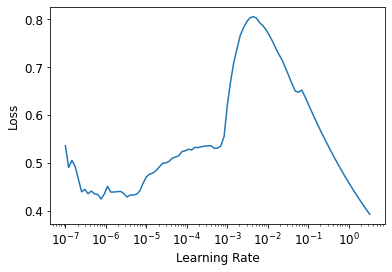

In [106]:
learn2.lr_find()

In [107]:
learn2.fit(10, 0.033113)

epoch,train_loss,valid_loss,accuracy,time
0,0.134051,1.865151,0.467800,00:02
1,0.133767,1.829728,0.471700,00:03
2,0.132202,1.776442,0.481700,00:03
3,0.130577,1.699984,0.494200,00:02
4,0.128296,1.623415,0.510900,00:02
5,0.125064,1.563546,0.523700,00:02
6,0.121635,1.516742,0.534300,00:02
7,0.118229,1.477539,0.545100,00:02
8,0.115057,1.440766,0.554600,00:02
9,0.112628,1.400758,0.563500,00:02


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.033113110810518265)

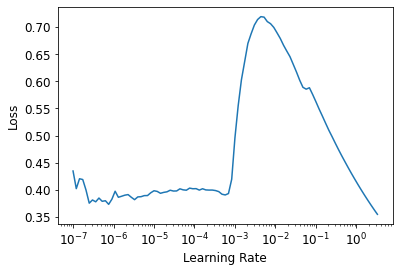

In [108]:
learn2.lr_find()

In [110]:
learn2.save("30epochs")

Path('models/30epochs.pth')

The learning rate finder keeps suggesting 0.033 so lets just train with that for 40 epochs.

In [111]:
learn2.fit(40, 0.033)

epoch,train_loss,valid_loss,accuracy,time
0,0.110545,1.364934,0.571500,00:02
1,0.108368,1.339307,0.579000,00:02
2,0.105852,1.319150,0.585900,00:02
3,0.103238,1.301200,0.591900,00:02
4,0.100862,1.284787,0.596600,00:02
5,0.098742,1.264970,0.601900,00:02
6,0.096835,1.241143,0.607100,00:02
7,0.095052,1.214417,0.612100,00:03
8,0.093339,1.186153,0.618500,00:03
9,0.091567,1.158355,0.624900,00:03


In [112]:
learn2.save("70epochs")

Path('models/70epochs.pth')

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=0.033113110810518265)

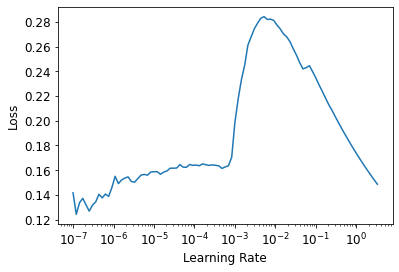

In [113]:
learn2.lr_find()

Still the same learning rate is suggested! Ok lets keep going!

In [114]:
learn2.fit(40, 0.0331)

epoch,train_loss,valid_loss,accuracy,time
0,0.055585,0.515714,0.819700,00:03
1,0.054741,0.507054,0.822800,00:02
2,0.053889,0.498823,0.826700,00:02
3,0.053053,0.490465,0.830200,00:03
4,0.052273,0.482284,0.833000,00:02
5,0.051536,0.474165,0.835900,00:03
6,0.050819,0.465692,0.839300,00:02
7,0.050104,0.457426,0.842200,00:03
8,0.049399,0.449476,0.844800,00:03
9,0.048689,0.441929,0.847700,00:03


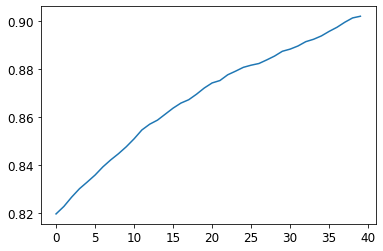

In [115]:
plt.plot(L(learn2.recorder.values).itemgot(2));

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.0964781722577754e-06)

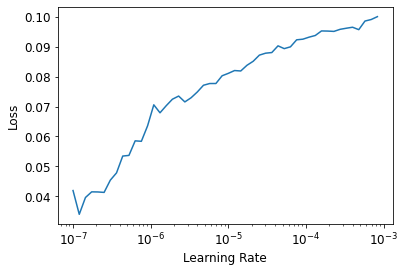

In [117]:
learn2.lr_find()

In [118]:
learn2.save("110epochs")

Path('models/110epochs.pth')

In [125]:
learn2.load("110epochs")

In [126]:
learn2.fit(10, 1.09647e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.172105,0.298283,0.902400,00:02
1,0.171536,0.297550,0.902800,00:02
2,0.170967,0.296821,0.902900,00:02
3,0.170402,0.296098,0.902900,00:02
4,0.169842,0.295379,0.903000,00:02
5,0.169286,0.294665,0.903300,00:03
6,0.168734,0.293956,0.903400,00:03
7,0.168187,0.293252,0.903900,00:03
8,0.167644,0.292553,0.904200,00:02
9,0.167105,0.291859,0.904600,00:02


We seem to have plateaued at 90.46% accuracy. Not bad!